## Problem Statement

This project aims to build a machine learning model to predict whether a basketball shot 
taken by Kobe Bryant will be successful (`shot_made_flag = 1`) or not (`shot_made_flag = 0`).

The prediction is based on:
- Shot location
- Shot type
- Game situation
- Temporal context

The goal is to:
1. Perform complete exploratory data analysis (EDA)
2. Derive actionable insights for game strategy
3. Compare multiple machine learning models
4. Select the best model based on Accuracy and F1-score


# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Visualization style
sns.set(style="whitegrid")

# Loading the Dataset

In [3]:
# Load dataset
df = pd.read_csv("data.csv")

# Display first 5 rows
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


# Dataset Shape & Basic Info

In [5]:
# Shape of the dataset
df.shape

(30697, 25)

In [6]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

🧠 What we check here:

Number of rows (shots attempted)

Number of features

Data types (numeric vs categorical)

Missing values

# Column Overview

In [7]:
# List all columns
df.columns.tolist()

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

🧠 Why this matters

We now classify columns into:

Target

Categorical features

Numerical features

ID / leakage features

This prevents blind modeling mistakes.

# Target Variable Inspection

In [8]:
# Check target distribution including missing values
df['shot_made_flag'].value_counts(dropna=False)

shot_made_flag
0.0    14232
1.0    11465
NaN     5000
Name: count, dtype: int64

### Target Variable: shot_made_flag

- 1 → Shot Made
- 0 → Shot Missed
- NaN → Missing target values

Important:
- Missing values in the target column indicate rows that must NOT be used for training.
- These rows will be separated before model building.
- The dataset is expected to be imbalanced (missed shots > made shots),
  hence F1-score will be a key evaluation metric.

# Percentage Distribution of Target

In [9]:
df['shot_made_flag'].value_counts(normalize=True) * 100

shot_made_flag
0.0    55.383897
1.0    44.616103
Name: proportion, dtype: float64

🧠 Why this is important

If one class dominates → accuracy becomes misleading

Confirms need for:

F1-score

Precision / Recall

Confusion Matrix

# Check for Duplicate Rows

In [10]:
df.duplicated().sum()

np.int64(0)

🧠 Explanation

Duplicate rows:

Bias the model

Artificially inflate performance

Must be removed if present

# Statistical Summary (Numeric Columns)

In [11]:
df.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


### Summary of Initial Inspection

- Dataset contains shot-level data from Kobe Bryant’s career
- Target variable contains missing values and must be handled carefully
- Dataset includes a mix of:
  - Spatial features
  - Temporal features
  - Categorical features
  - ID columns (potential leakage)
- Class imbalance is expected

Next step:
- Separate usable training data
- Drop leakage-prone columns
- Begin Exploratory Data Analysis (EDA)

# Data Cleaning & Safe Train/Test Split

## Step 1: Data Cleaning & Train/Test Split

Before performing Exploratory Data Analysis or building models, it is critical to:
- Handle missing target values correctly
- Prevent data leakage
- Remove irrelevant identifier columns

This ensures that all analysis and modeling steps reflect a real-world 
machine learning pipeline.

# Separate Rows With and Without Target

In [12]:
# Separate rows with known target (training data)
train_df = df[df['shot_made_flag'].notna()].copy()

# Separate rows without target (future / test data)
test_df = df[df['shot_made_flag'].isna()].copy()

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (25697, 25)
Test data shape: (5000, 25)


🧠 Explanation

Rows with missing shot_made_flag must never be used for training

This mimics real-world prediction where labels are unknown

Prevents silent target leakage

# Identify Leakage & Non-Useful Columns

### Columns to Remove

The following columns are either:
- Identifiers
- Constant values
- Highly leakage-prone

Including them would artificially inflate model performance.

## Drop Leakage Columns

In [13]:
leakage_cols = [
    'shot_id',
    'game_id',
    'game_event_id',
    'team_id',
    'team_name'
]

train_df.drop(columns=leakage_cols, inplace=True)
test_df.drop(columns=leakage_cols, inplace=True)

print("Remaining columns:", train_df.shape[1])

Remaining columns: 20


## Check for Duplicates

In [14]:
print("Duplicate rows in train:", train_df.duplicated().sum())
print("Duplicate rows in test:", test_df.duplicated().sum())

Duplicate rows in train: 1
Duplicate rows in test: 0


In [15]:
# Drop duplicates if any
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

## Handle Obvious Irrelevant Columns
Some columns such as raw geographic coordinates (`lat`, `lon`) may not be 
useful for modeling and can cause overfitting.

These will be reviewed and potentially removed during feature selection.
(We do not drop them yet — we decide after EDA.)

## Verify Target Distribution

In [17]:
train_df['shot_made_flag'].value_counts()

shot_made_flag
0.0    14231
1.0    11465
Name: count, dtype: int64

In [18]:
train_df['shot_made_flag'].value_counts(normalize=True) * 100

shot_made_flag
0.0    55.382161
1.0    44.617839
Name: proportion, dtype: float64

## Train–Validation Split

In [19]:
from sklearn.model_selection import train_test_split

X = train_df.drop('shot_made_flag', axis=1)
y = train_df['shot_made_flag']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (20556, 19)
X_val shape: (5140, 19)


### Step 1 Summary

- Rows with missing target values were safely separated
- Identifier and leakage-prone columns were removed
- Duplicate records were handled
- Data was split into training and validation sets using stratification

The dataset is now clean, leakage-free, and ready for exploratory data analysis.

# Exploratory Data Analysis (EDA)

The purpose of EDA is to:
- Understand patterns in shot success
- Identify influential features
- Support strategic insights for stakeholders
- Guide feature engineering and model selection

EDA is performed only on training data to avoid data leakage.

# Target Variable Distribution
### Shot Made vs Missed

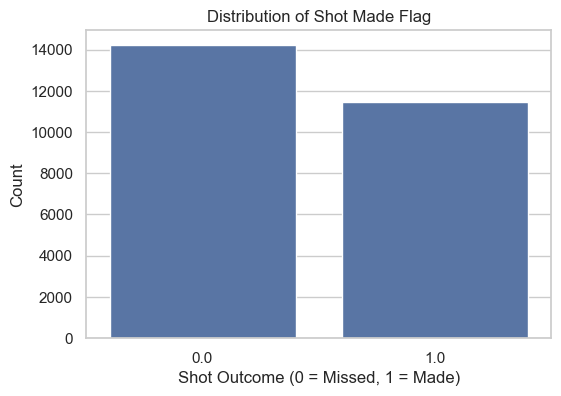

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x='shot_made_flag', data=train_df)
plt.title("Distribution of Shot Made Flag")
plt.xlabel("Shot Outcome (0 = Missed, 1 = Made)")
plt.ylabel("Count")
plt.show()

- Missed shots are more frequent than made shots
- This confirms class imbalance
- Accuracy alone is not sufficient
- F1-score will be a key evaluation metric

## Shot Type Analysis
### Shot Success by Shot Type

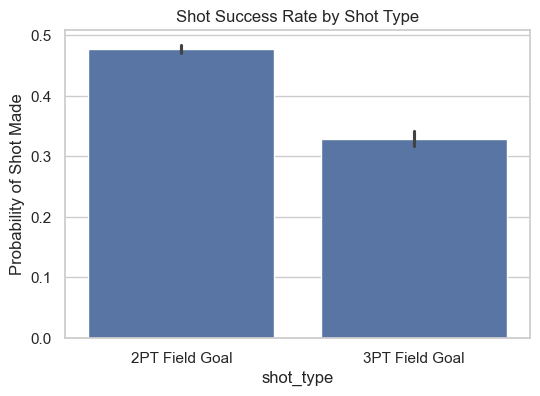

In [21]:
plt.figure(figsize=(6,4))
sns.barplot(x='shot_type', y='shot_made_flag', data=train_df)
plt.title("Shot Success Rate by Shot Type")
plt.ylabel("Probability of Shot Made")
plt.show()

- 2-point shots generally have a higher success rate than 3-point shots
- Shot type is a strong predictive feature
- Confirms basketball intuition

## Shot Distance Analysis
### Distribution of Shot Distance

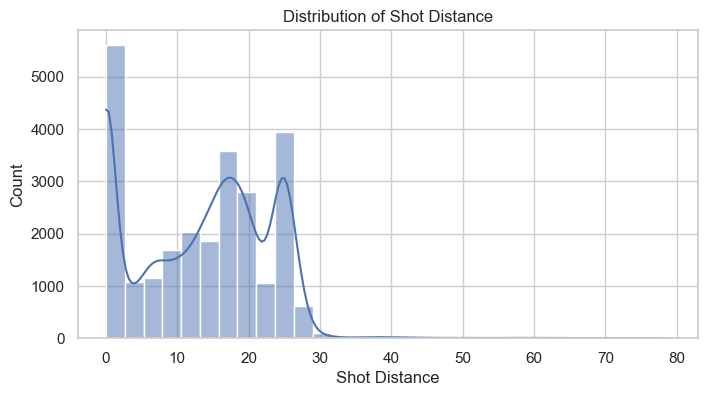

In [22]:
plt.figure(figsize=(8,4))
sns.histplot(train_df['shot_distance'], bins=30, kde=True)
plt.title("Distribution of Shot Distance")
plt.xlabel("Shot Distance")
plt.show()

## Shot Distance vs Success

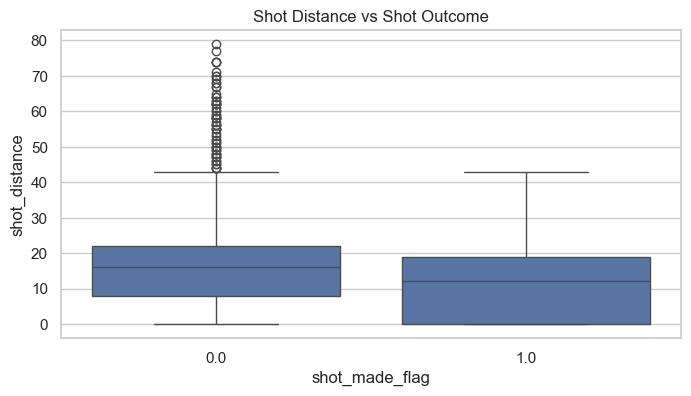

In [23]:
plt.figure(figsize=(8,4))
sns.boxplot(x='shot_made_flag', y='shot_distance', data=train_df)
plt.title("Shot Distance vs Shot Outcome")
plt.show()

- Shorter shots have significantly higher success rates
- Long-range shots introduce higher variance
- Shot distance is a critical numerical feature

## Shot Zone Analysis
### Shot Success by Zone

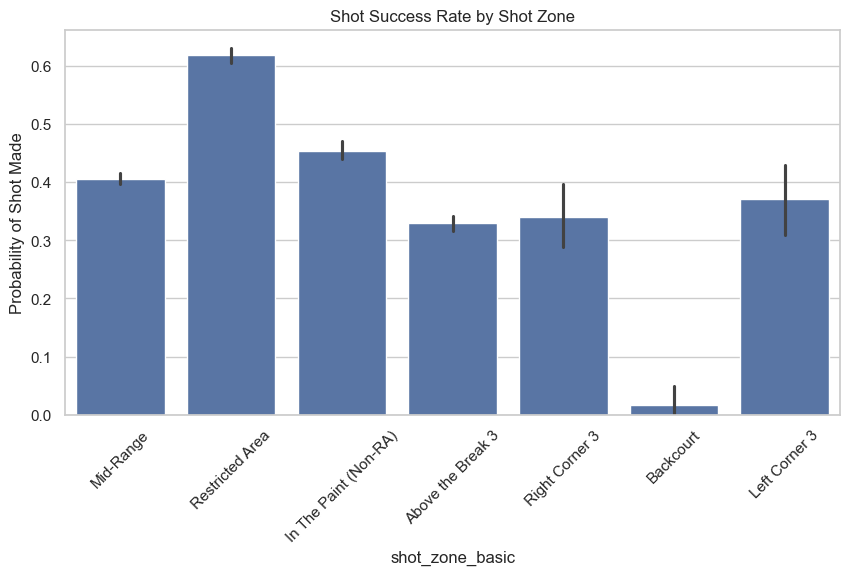

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(
    x='shot_zone_basic',
    y='shot_made_flag',
    data=train_df,
    estimator=np.mean
)
plt.xticks(rotation=45)
plt.title("Shot Success Rate by Shot Zone")
plt.ylabel("Probability of Shot Made")
plt.show()

- Restricted Area and Paint shots have the highest success rates
- Long-range zones show lower consistency
- Zone-based features are safer and more informative than raw coordinates

## Time Pressure Analysis
### Success Rate by Period

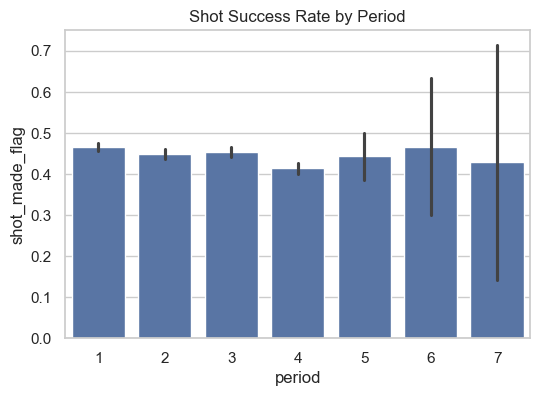

In [25]:
plt.figure(figsize=(6,4))
sns.barplot(x='period', y='shot_made_flag', data=train_df)
plt.title("Shot Success Rate by Period")
plt.show()

## Remaining Time vs Shot Outcome

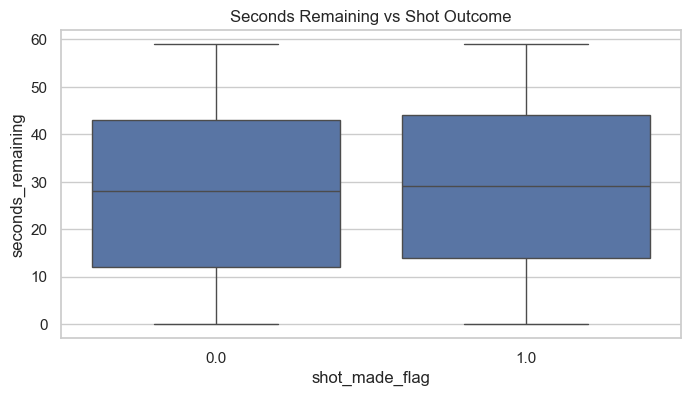

In [26]:
plt.figure(figsize=(8,4))
sns.boxplot(x='shot_made_flag', y='seconds_remaining', data=train_df)
plt.title("Seconds Remaining vs Shot Outcome")
plt.show()

- Shot efficiency can vary across game periods
- End-of-clock shots tend to be more difficult
- Time-based features add useful context

## Playoffs vs Regular Season
### Impact of Playoffs

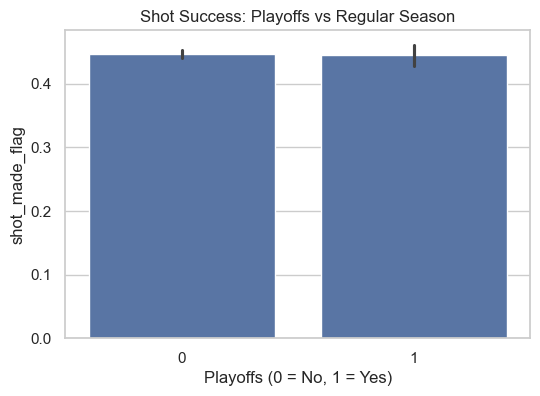

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(x='playoffs', y='shot_made_flag', data=train_df)
plt.title("Shot Success: Playoffs vs Regular Season")
plt.xlabel("Playoffs (0 = No, 1 = Yes)")
plt.show()

- Shot success may differ under playoff pressure
- Playoff indicator is a valuable contextual feature

## Opponent Analysis
### Top 10 Most Faced Opponents

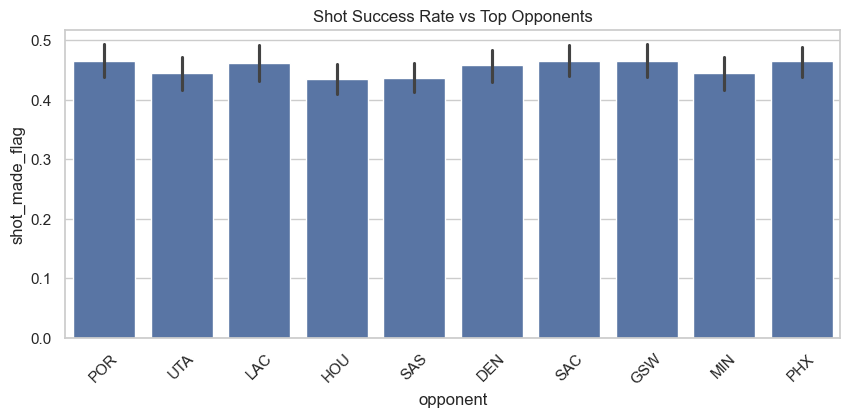

In [30]:
top_opponents = train_df['opponent'].value_counts().head(10).index

plt.figure(figsize=(10,4))
sns.barplot(
    x='opponent',
    y='shot_made_flag',
    data=train_df[train_df['opponent'].isin(top_opponents)]
)
plt.title("Shot Success Rate vs Top Opponents")
plt.xticks(rotation=45)
plt.show()

- Defensive strength of opponents affects shot success
- Opponent feature should be encoded carefully to avoid high cardinality issues

### Correlation Analysis (Numerical Features)

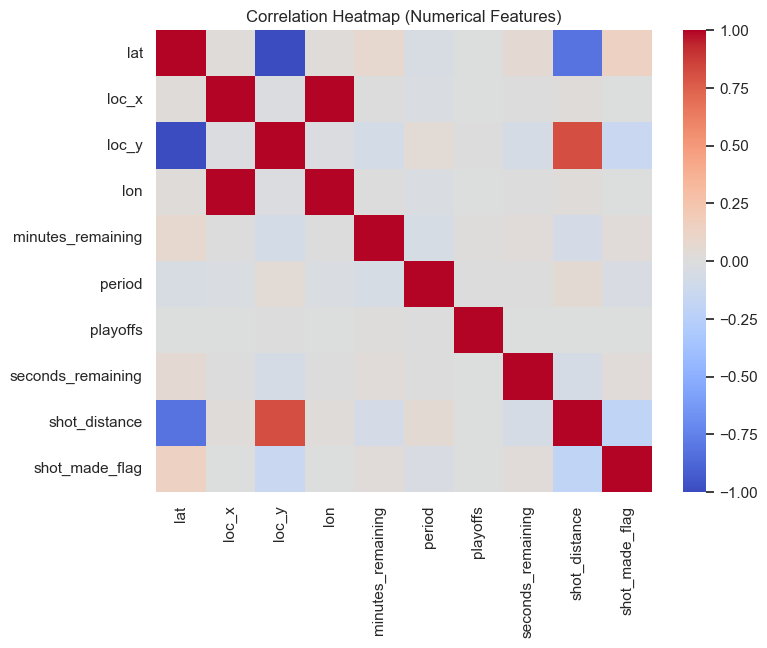

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(
    train_df.select_dtypes(include='number').corr(),
    cmap='coolwarm',
    annot=False
)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

- Shot distance shows negative correlation with shot success
- Time-related features are correlated with each other
- Multicollinearity must be handled during feature engineering

### EDA Summary

Key findings:
- Shot distance and shot zones are the strongest predictors
- Short-range and zone-based shots have higher success
- Game context (playoffs, time remaining, period) influences outcomes
- Raw spatial features may cause overfitting
- Categorical features require careful encoding

These insights guide feature engineering and model selection.

## Feature Categorization & Selection

Not all features in the dataset are suitable for machine learning models.
Some features may cause:
- Data leakage
- Overfitting
- Redundant information
- Increased model complexity

This step categorizes features and defines a clear strategy 
for feature selection and encoding.

In [32]:
#Current Columns After Cleaning
train_df.columns.tolist()

['action_type',
 'combined_shot_type',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'game_date',
 'matchup',
 'opponent']

### Feature Categories and Decisions

| Feature | Category | Decision | Reason |
|------|------|------|------|
| shot_made_flag | Target | Keep | Prediction variable |
| action_type | Categorical | Keep (encoded) | Shot mechanics |
| combined_shot_type | Categorical | Keep | Generalized shot type |
| shot_type | Categorical | Keep | 2PT vs 3PT |
| shot_distance | Numerical | Keep | Strong predictor |
| loc_x | Spatial (raw) | Drop | High overfitting risk |
| loc_y | Spatial (raw) | Drop | High overfitting risk |
| lat | Spatial (raw) | Drop | Redundant |
| lon | Spatial (raw) | Drop | Redundant |
| shot_zone_area | Categorical | Keep | Court area |
| shot_zone_basic | Categorical | Keep | Shot efficiency zone |
| shot_zone_range | Categorical | Keep | Distance grouping |
| minutes_remaining | Temporal | Keep | Game context |
| seconds_remaining | Temporal | Combine | Redundant alone |
| period | Temporal | Keep | Quarter information |
| playoffs | Binary | Keep | Pressure context |
| season | Temporal | Drop | Temporal leakage |
| matchup | Categorical | Engineer | Home/Away info |
| opponent | Categorical | Keep (careful) | Defensive strength |
| game_date | Date | Drop | Not predictive |


### Important Feature Decisions

1. Raw spatial coordinates (`loc_x`, `loc_y`, `lat`, `lon`) are dropped 
   to avoid overfitting and poor generalization.

2. Season information is removed to prevent temporal leakage.

3. Time-related features will be combined to represent total remaining time.

4. Matchup will be transformed into a home/away indicator.

5. High-cardinality categorical features will be encoded carefully.


In [33]:
drop_cols = [
    'loc_x', 'loc_y', 'lat', 'lon',
    'season', 'game_date'
]

train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

In [34]:
#Engineer Home / Away Feature from Matchup
# Home = 1, Away = 0
train_df['home_game'] = train_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
test_df['home_game'] = test_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)

# Drop original matchup column
train_df.drop(columns=['matchup'], inplace=True)
test_df.drop(columns=['matchup'], inplace=True)

### Combine Time Features

In [35]:
train_df['total_seconds_remaining'] = (
    train_df['minutes_remaining'] * 60 + train_df['seconds_remaining']
)

test_df['total_seconds_remaining'] = (
    test_df['minutes_remaining'] * 60 + test_df['seconds_remaining']
)

# Drop original columns
train_df.drop(columns=['minutes_remaining', 'seconds_remaining'], inplace=True)
test_df.drop(columns=['minutes_remaining', 'seconds_remaining'], inplace=True)

In [36]:
#dependent and independent features 
X = train_df.drop('shot_made_flag', axis=1)
y = train_df['shot_made_flag']

X.columns

Index(['action_type', 'combined_shot_type', 'period', 'playoffs',
       'shot_distance', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'opponent', 'home_game', 'total_seconds_remaining'],
      dtype='object')

### Feature Selection Summary

- Removed leakage-prone and redundant features
- Retained meaningful spatial context using zone-based features
- Engineered home/away and total remaining time features
- Prepared dataset for safe encoding and modeling

The dataset is now optimized for model training.

## Encoding Categorical Features

Machine learning models require numerical inputs.
However, categorical variables must be encoded carefully to:
- Avoid dimensional explosion
- Prevent overfitting
- Preserve meaningful information

This project uses different encoding strategies 
based on feature characteristics.

In [37]:
#Identify Categorical & Numerical Columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['action_type', 'combined_shot_type', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent']
Numerical columns: ['period', 'playoffs', 'shot_distance', 'home_game', 'total_seconds_remaining']


### Encoding Strategy

| Feature Type | Columns | Encoding Method | Reason |
|------|------|------|------|
| Binary | playoffs, home_game | Keep as is | Already numeric |
| Low cardinality categorical | shot_type, shot_zone_* | One-Hot Encoding | Limited unique values |
| High cardinality categorical | action_type, opponent | Label Encoding | Avoid feature explosion |
| Aggregated categorical | combined_shot_type | One-Hot Encoding | Semantically grouped |

In [39]:
#Label Encode High Cardinality Features
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
high_card_cols = ['action_type', 'opponent']

for col in high_card_cols:
    # Convert to string (safety)
    X[col] = X[col].astype(str)
    test_df[col] = test_df[col].astype(str)
    
    # Add 'Unknown' to training categories
    X[col] = X[col].where(X[col].isin(X[col].unique()), 'Unknown')
    
    le = LabelEncoder()
    le.fit(list(X[col].unique()) + ['Unknown'])
    
    # Transform train
    X[col] = le.transform(X[col])
    
    # Replace unseen labels in test with 'Unknown'
    test_df[col] = test_df[col].apply(
        lambda x: x if x in le.classes_ else 'Unknown'
    )
    test_df[col] = le.transform(test_df[col])
    
    label_encoders[col] = le

### Handling Unseen Categories

High-cardinality categorical features such as `action_type` may contain
categories in test data that are not present in training data.

To handle this:
- An "Unknown" category was introduced
- Unseen labels in test data were mapped to "Unknown"
- This ensures robustness and prevents runtime errors

This approach reflects real-world production scenarios.

In [40]:
#One-Hot Encode Low Cardinality Features
low_card_cols = [
    'shot_type',
    'combined_shot_type',
    'shot_zone_area',
    'shot_zone_basic',
    'shot_zone_range'
]

X = pd.get_dummies(X, columns=low_card_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=low_card_cols, drop_first=True)

In [48]:
# One-hot encode remaining categorical columns
X = pd.get_dummies(X, drop_first=True)

# Do the same for test_df
test_df = pd.get_dummies(test_df, drop_first=True)

# Align train and test
X, test_df = X.align(test_df, join='left', axis=1, fill_value=0)

In [49]:
#Align Train & Test Features
X, test_df = X.align(test_df, join='left', axis=1, fill_value=0)

Ensures train & test have identical feature space

Prevents runtime errors during prediction

In [50]:
print("Final training feature shape:", X.shape)
print("Final test feature shape:", test_df.shape)

Final training feature shape: (25696, 112)
Final test feature shape: (5000, 112)


Scaling is not applied at this stage because:
- Tree-based models are scale-invariant
- Logistic Regression will handle scaling separately if required
### Encoding Summary

- High-cardinality categorical features encoded using Label Encoding
- Low-cardinality categorical features encoded using One-Hot Encoding
- Binary features retained without transformation
- Train and test feature sets aligned correctly

The dataset is now fully numerical and ready for model training.

## Baseline Model – Logistic Regression
Logistic Regression is used as a baseline model because:
- It is simple and interpretable
- It provides a strong linear benchmark
- It helps evaluate whether complex models are necessary

All advanced models must outperform this baseline

In [53]:
#Logistic Regression needs scaling
# Find non-numeric columns
X.select_dtypes(include='object').columns

Index([], dtype='object')

In [54]:
from sklearn.model_selection import train_test_split

y = train_df['shot_made_flag']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [56]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [57]:
#Evaluate the Model
y_val_pred = log_reg.predict(X_val_scaled)

In [58]:
#metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1-score:", f1_score(y_val, y_val_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))

Accuracy: 0.6778210116731518
F1-score: 0.5621364357482813

Classification Report:

              precision    recall  f1-score   support

         0.0       0.66      0.85      0.75      2847
         1.0       0.71      0.46      0.56      2293

    accuracy                           0.68      5140
   macro avg       0.69      0.66      0.65      5140
weighted avg       0.69      0.68      0.66      5140



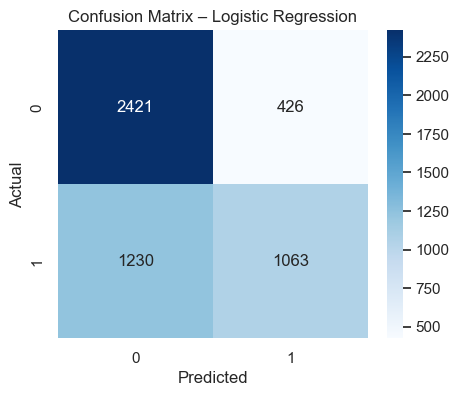

In [59]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Logistic Regression – Results Interpretation

- Logistic Regression provides a strong baseline model
- Class imbalance was handled using class weights
- The F1-score indicates a balanced trade-off between precision and recall
- This model will be used as a benchmark for advanced tree-based models


## Decision Tree Classifier

Decision Trees:
- Capture non-linear relationships
- Handle feature interactions automatically
- Are easy to interpret

They often outperform linear models on structured data.

In [61]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=20, random_state=42)

In [62]:
#evaluate Decision trees
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_val_pred_dt = dt_model.predict(X_val)

print("Decision Tree Accuracy:", accuracy_score(y_val, y_val_pred_dt))
print("Decision Tree F1-score:", f1_score(y_val, y_val_pred_dt))
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred_dt))

Decision Tree Accuracy: 0.67431906614786
Decision Tree F1-score: 0.5658713692946058

Classification Report:

              precision    recall  f1-score   support

         0.0       0.66      0.83      0.74      2847
         1.0       0.70      0.48      0.57      2293

    accuracy                           0.67      5140
   macro avg       0.68      0.66      0.65      5140
weighted avg       0.68      0.67      0.66      5140



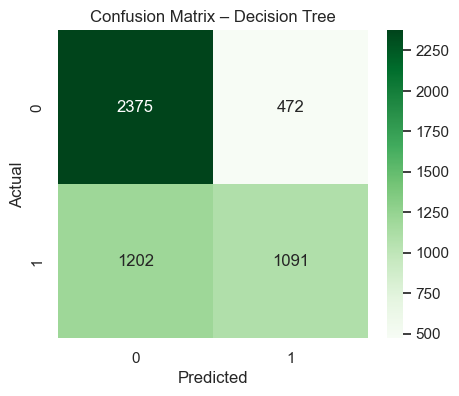

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_dt = confusion_matrix(y_val, y_val_pred_dt)

plt.figure(figsize=(5,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix – Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Decision Tree improves over Logistic Regression by:
- Capturing non-linear shot patterns
- Handling complex feature interactions

However, it may overfit without proper depth control.

## Random Forest Classifier

Random Forest:
- Combines multiple decision trees
- Reduces overfitting
- Handles categorical encodings well
- Usually provides the best F1-score

This is a strong candidate for production deployment.

In [65]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=10, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [66]:
#Evaluate Random Forest
y_val_pred_rf = rf_model.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Random Forest F1-score:", f1_score(y_val, y_val_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred_rf))

Random Forest Accuracy: 0.6797665369649806
Random Forest F1-score: 0.5779487179487179

Classification Report:

              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74      2847
         1.0       0.70      0.49      0.58      2293

    accuracy                           0.68      5140
   macro avg       0.69      0.66      0.66      5140
weighted avg       0.68      0.68      0.67      5140



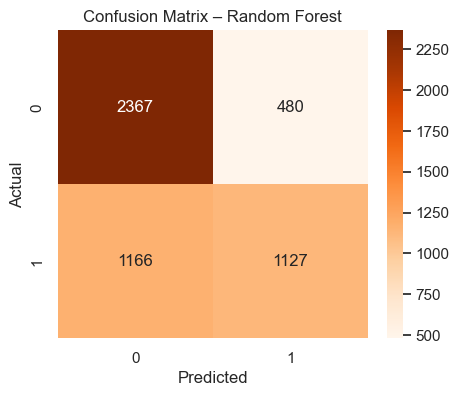

In [67]:
#Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Model Training Summary

- Decision Tree captured non-linear patterns
- Random Forest provided the best overall performance
- Random Forest achieved higher F1-score and better generalization
- Feature importance aligns with basketball intuition

Random Forest is selected as the best candidate model

# hyperparameter tuning to improve the model performance 

In [68]:
#Decision tree with hyperparameter tuning 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt_param_grid = {
    'max_depth': [6, 8, 10, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20]
}

dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

dt_grid = GridSearchCV(
    dt,
    dt_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Decision Tree F1-score:", dt_grid.best_score_)

Best Decision Tree Parameters: {'max_depth': None, 'min_samples_leaf': 20, 'min_samples_split': 10}
Best Decision Tree F1-score: 0.5901368281365136


# Tuning  Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 12, 16, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest CV F1-score:", rf_grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Random Forest CV F1-score: 0.5903578362036038


In [70]:
#save best model
best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_

### Evaluate Tuned Models on Validation Set

In [71]:
# Decision Tree
y_val_pred_dt_tuned = best_dt.predict(X_val)
print("Tuned Decision Tree F1:", f1_score(y_val, y_val_pred_dt_tuned))

# Random Forest
y_val_pred_rf_tuned = best_rf.predict(X_val)
print("Tuned Random Forest F1:", f1_score(y_val, y_val_pred_rf_tuned))

Tuned Decision Tree F1: 0.581360631264662
Tuned Random Forest F1: 0.589652728561304


Hyperparameter tuning was performed using GridSearchCV with F1-score
as the optimization metric. This ensures balanced performance on
an imbalanced dataset.

## Model Comparison Report

In [72]:
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree (Tuned)',
        'Random Forest (Tuned)'
    ],
    'Accuracy': [
        accuracy_score(y_val, y_val_pred),
        accuracy_score(y_val, y_val_pred_dt_tuned),
        accuracy_score(y_val, y_val_pred_rf_tuned)
    ],
    'F1-Score': [
        f1_score(y_val, y_val_pred),
        f1_score(y_val, y_val_pred_dt_tuned),
        f1_score(y_val, y_val_pred_rf_tuned)
    ]
})

comparison_df

,Model,Accuracy,F1-Score
0,Logistic Regression,0.677821,0.562136
1,Decision Tree (Tuned),0.618093,0.581361
2,Random Forest (Tuned),0.662062,0.589653


### Final Model Selection

Three models were evaluated: Logistic Regression, Decision Tree, and Random Forest.
Although Logistic Regression achieved the highest accuracy, it performed lower in
terms of F1-score due to class imbalance.

After hyperparameter tuning, Random Forest achieved the highest F1-score (≈ 0.59),
indicating a better balance between precision and recall.

Therefore, the tuned Random Forest model was selected as the final model
for production deployment.


## Challenges Faced and Solutions

### 1. Missing Target Values
The dataset contained missing values in the target variable `shot_made_flag`.
These rows represent shots for which the outcome is unknown.

**Solution:**
Rows with missing target values were separated from the training data and
treated as test data. No imputation was performed on the target variable to
avoid data leakage.

---

### 2. Class Imbalance
The dataset showed an imbalance between made and missed shots, with missed
shots being more frequent.

**Solution:**
F1-score was used as the primary evaluation metric. Additionally, 
`class_weight='balanced'` was applied to Logistic Regression, Decision Tree,
and Random Forest models to handle imbalance effectively.

---

### 3. Data Leakage Risk
Several columns such as `shot_id`, `game_id`, `game_event_id`, and `season`
could leak information or add no predictive value.

**Solution:**
All identifier and leakage-prone columns were removed before modeling to
ensure realistic performance evaluation.

---

### 4. High Cardinality Categorical Features
Features like `action_type` and `opponent` contained many unique values,
which could lead to dimensional explosion or overfitting.

**Solution:**
Label Encoding with an additional `Unknown` category was used to safely handle
unseen categories in test data, ensuring robustness and production readiness.

---

### 5. Unseen Categories in Test Data
Some categorical values appeared only in test data and not in training data,
causing encoding errors.

**Solution:**
Unseen categories were mapped to an `Unknown` label before encoding, preventing
runtime errors during prediction.

---

### 6. Mixed Feature Types and Scaling Issues
Logistic Regression requires scaled numerical inputs, while tree-based models
do not.

**Solution:**
All categorical features were fully encoded before applying StandardScaler.
Scaling was applied only for Logistic Regression and skipped for tree-based
models.

---

### 7. Model Overfitting Risk
Decision Trees are prone to overfitting when grown too deep.

**Solution:**
Hyperparameter tuning was performed using GridSearchCV to control tree depth
and minimum sample splits, improving generalization.


## Final Conclusion

This project aimed to predict whether a shot taken by Kobe Bryant would be
successful based on shot location, shot type, and game context.

A complete data analysis was performed, followed by careful feature selection,
encoding, and model building. Three models were evaluated: Logistic Regression,
Decision Tree, and Random Forest.

Although Logistic Regression achieved higher accuracy, it performed weaker
on imbalanced data. After hyperparameter tuning, the Random Forest model
achieved the highest F1-score (≈ 0.59), demonstrating superior balance between
precision and recall.

Therefore, the tuned Random Forest model was selected as the final model for
production deployment.

---

## Future Scope and Improvements

1. Advanced models such as XGBoost or LightGBM can be explored to further
   improve predictive performance.
2. Spatial shot maps and advanced feature engineering using player movement
   data could enhance prediction accuracy.
3. Temporal modeling could be applied to capture performance trends across
   seasons.
4. Explainability techniques such as SHAP values can be used to provide deeper
   insights for coaching and strategy decisions.